In [1]:
import numpy
import matplotlib
from matplotlib import pyplot
import tensorflow as tf
import cv2
import os
from glob import glob
pyplot.rcParams['figure.figsize'] = [15, 10]

In [2]:
print(f'numpy     : {numpy.__version__}')
print(f'matplotlib: {matplotlib.__version__}')
print(f'tensorflow: {tf.__version__}')
print(f'opencv    : {cv2.__version__}')

numpy     : 1.23.5
matplotlib: 3.7.1
tensorflow: 2.9.1
opencv    : 4.7.0


In [3]:
def load_image(filename: str):
    image = cv2.imread(filename)
    one_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    one_img = cv2.resize(one_img, (256, 256))
    w = (one_img.shape[1]//32)*32
    h = (one_img.shape[0]//32)*32
    one_img = one_img[:h, :w].astype(dtype=numpy.float32)/255.0
    one_img.shape=(1, h, w, 3)
    return one_img

In [4]:
model_greed: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_greed_model', compile=False)
model_greed.treniable = False
model_greed.compile()

In [6]:
model_cnn: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_cnn_model', compile=False)
model_cnn.treniable = False
model_cnn.compile()

In [7]:
model_mixer: tf.keras.Model = tf.keras.models.load_model('cat_vs_dog_mixer_model', compile=False)
model_mixer.treniable = False
model_mixer.compile()

In [5]:
classes = ['Cat', 'Dog']

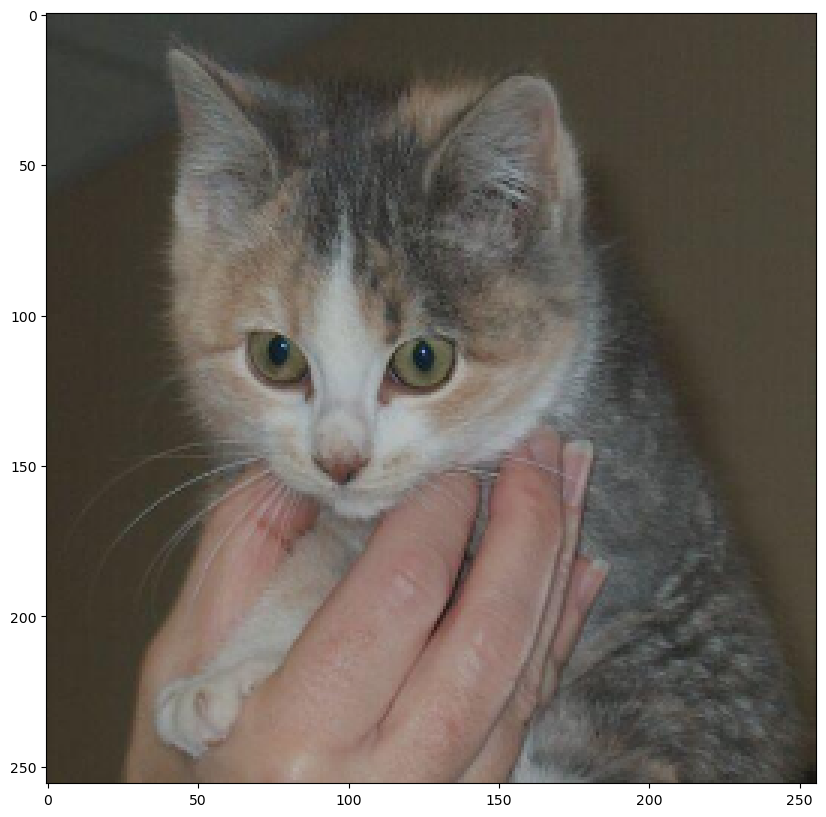

1/1 [==============================] - 0s 71ms/step
Cat
Cat
Cat


In [37]:
image_filename = './data/PetImages/Cat/10002.jpg'
# image_filename = './data/PetImages/Dog/311.jpg'
img = load_image(image_filename)
pyplot.imshow(img[0])
pyplot.show()
target_greed = model_greed.predict(img)
target_cnn   = model_cnn.predict(img)
target_mixer = model_mixer.predict(img)
print(classes[target_greed.argmax()])
print(classes[target_cnn.argmax()])
print(classes[target_mixer.argmax()])

In [10]:
def process(model: tf.keras.Model, image, target_out, weight_class=5.0, weight_blur=1.0, err_method='abs'):
    history = list()
    print(target_out.shape)
    image_init = image.copy()

    video_writer = cv2.VideoWriter('transform.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, (256, 256))

    # High frequency filter
    def make_tf_filter_3x3(filter_3x3):
        filter_tf = numpy.zeros(shape=(3, 3, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_3x3
        filter_tf[:, :, 1, 1] = filter_3x3
        filter_tf[:, :, 2, 2] = filter_3x3
        return tf.constant(value=filter_tf, dtype=tf.float32)

    def make_tf_filter_5x5(filter_5x5):
        filter_tf = numpy.zeros(shape=(5, 5, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_5x5
        filter_tf[:, :, 1, 1] = filter_5x5
        filter_tf[:, :, 2, 2] = filter_5x5
        return tf.constant(value=filter_tf, dtype=tf.float32)

    ## Filters 
    # sobel_h = numpy.array([[0.2, 0.6, 0.2],[0.0, 0.0, 0.0],[-0.2,-0.6,-0.2]], dtype=numpy.float32)
    # sobel_h = make_tf_filter_3x3(sobel_h)
    # sobel_w = numpy.array([[0.2, 0.0,-0.2],[0.6, 0.0,-0.6],[ 0.2, 0.0,-0.2]], dtype=numpy.float32)
    # sobel_w = make_tf_filter_3x3(sobel_w)

    sobel_h = numpy.array([[0.1, 0.2, 0.4, 0.2, 0.1], [0.1, 0.1, 0.2, 0.1, 0.1], [0.0, 0.0, 0.0, 0.0, 0.0], [-0.1,-0.1,-0.2,-0.1,-0.1], [-0.1,-0.2,-0.4,-0.2,-0.1]], dtype=numpy.float32)
    sobel_h = make_tf_filter_5x5(sobel_h)
    sobel_w = numpy.array([[0.1, 0.1, 0.0,-0.1,-0.1], [0.2, 0.1, 0.0,-0.1,-0.2], [0.4, 0.2, 0.0,-0.2,-0.4], [ 0.2, 0.1, 0.0,-0.1,-0.2], [ 0.1, 0.1, 0. ,-0.1,-0.1]], dtype=numpy.float32)
    sobel_w = make_tf_filter_5x5(sobel_w)

    s=1

    if err_method=='abs':
        err_type = tf.abs
    else:
        err_type = tf.square

    optimaser = tf.keras.optimizers.Adam(name='optimaser')# learning_rate=0.001, )

    image_init = tf.Variable(image_init)
    while True:
        for _ in range(10):
            with tf.GradientTape() as t:
                f = model(image_init)
                sh = tf.nn.conv2d(image_init, filters=sobel_h, strides=(1,1), padding='VALID')
                sw = tf.nn.conv2d(image_init, filters=sobel_w, strides=(1,1), padding='VALID')
                sh = err_type(sh)
                sw = err_type(sw)
                sh = tf.reduce_mean(sh)
                sw = tf.reduce_mean(sw)
                loss_markers = tf.reduce_mean(tf.square(target_out-f))*weight_class
                loss_sharpness = (sh+sw)*weight_blur
                loss = loss_markers + loss_sharpness
            history.append( [loss_markers.numpy(), loss_sharpness.numpy()] )
            gradients = t.gradient(loss, image_init)
            # image_init.assign_sub(gradient*5.0)
            optimaser.apply_gradients(zip([gradients], [image_init]))
            # image_init = tf.subtract(image_init, tf.reduce_min(image_init))
            # image_init = tf.divide(image_init, tf.reduce_max(image_init))
            # image_init = tf.Variable(image_init)
        if s<300:
            s=s+1
        else:
            break
        # class_of_init = model(image_init)
        # print(tf.reduce_max(gv).numpy())
        frame = (image_init.numpy()[0]*255).astype(dtype=numpy.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        class_name = classes[numpy.argmax(f.numpy()[0])]
        cv2.putText(frame, f'{class_name}: {numpy.max(f.numpy()[0]):.4f}', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
        cv2.imshow('processing_image', frame)
        video_writer.write(frame)
        K = cv2.waitKey(1)
        if K==27:
            break
    video_writer.release()
    del video_writer
    cv2.destroyAllWindows()

    pyplot.subplot(1, 3, 1)
    pyplot.imshow(image[0])
    pyplot.subplot(1, 3, 2)
    pyplot.imshow(image_init.numpy()[0]) #, vmin=0.0, vmax=1.0)
    pyplot.subplot(1, 3, 3)
    pyplot.imshow(cv2.Canny((image_init.numpy()[0, :, :, :]*255).astype(numpy.uint8), 10.0, 20.0)) #
    pyplot.show()
    return numpy.array(history), image_init.numpy()
# pyplot.imshow(class_of_init[0])
# pyplot.show()

(1, 2)


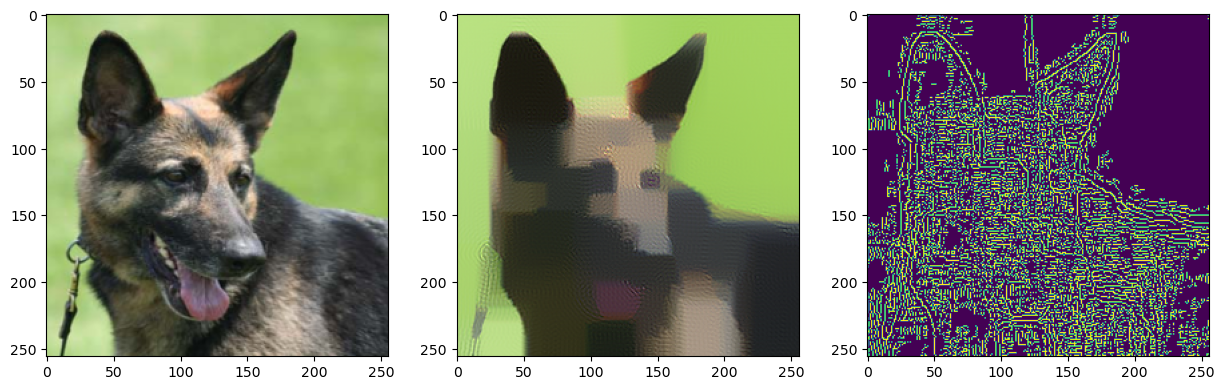

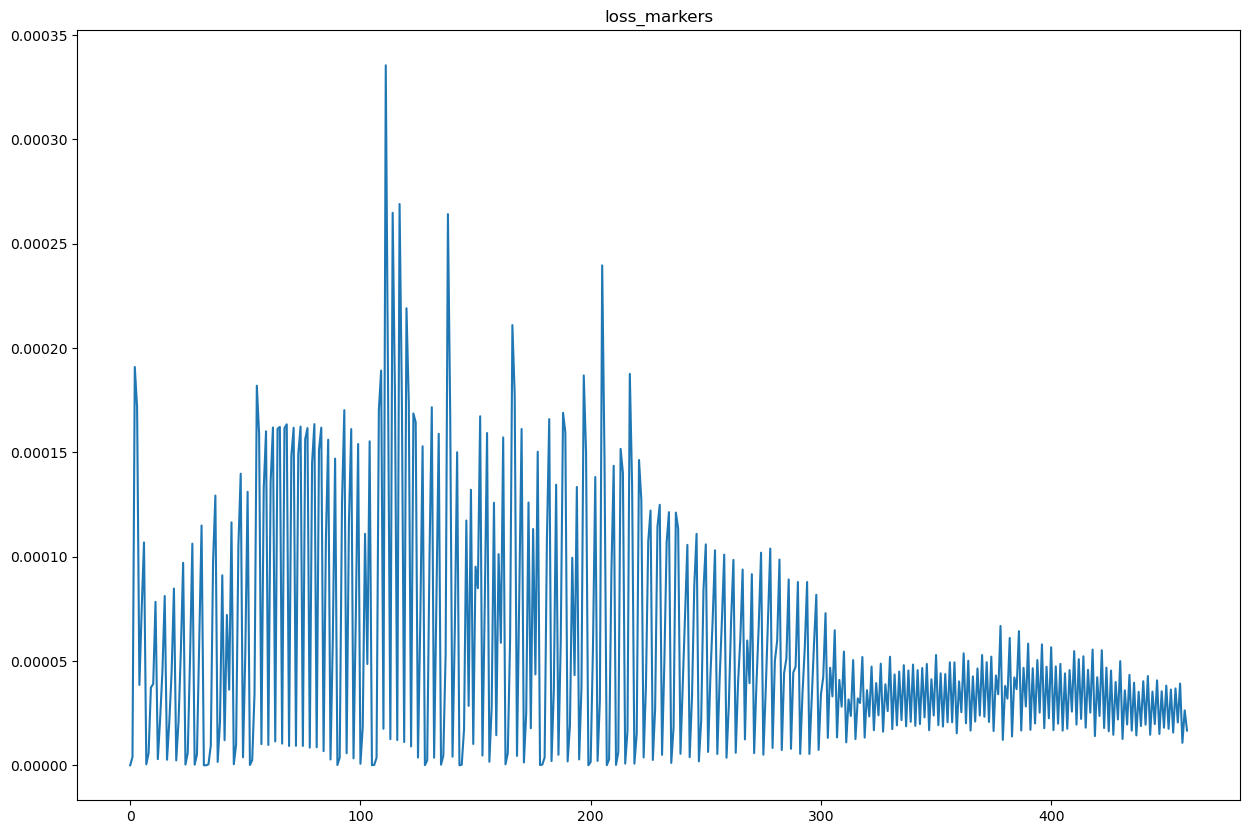

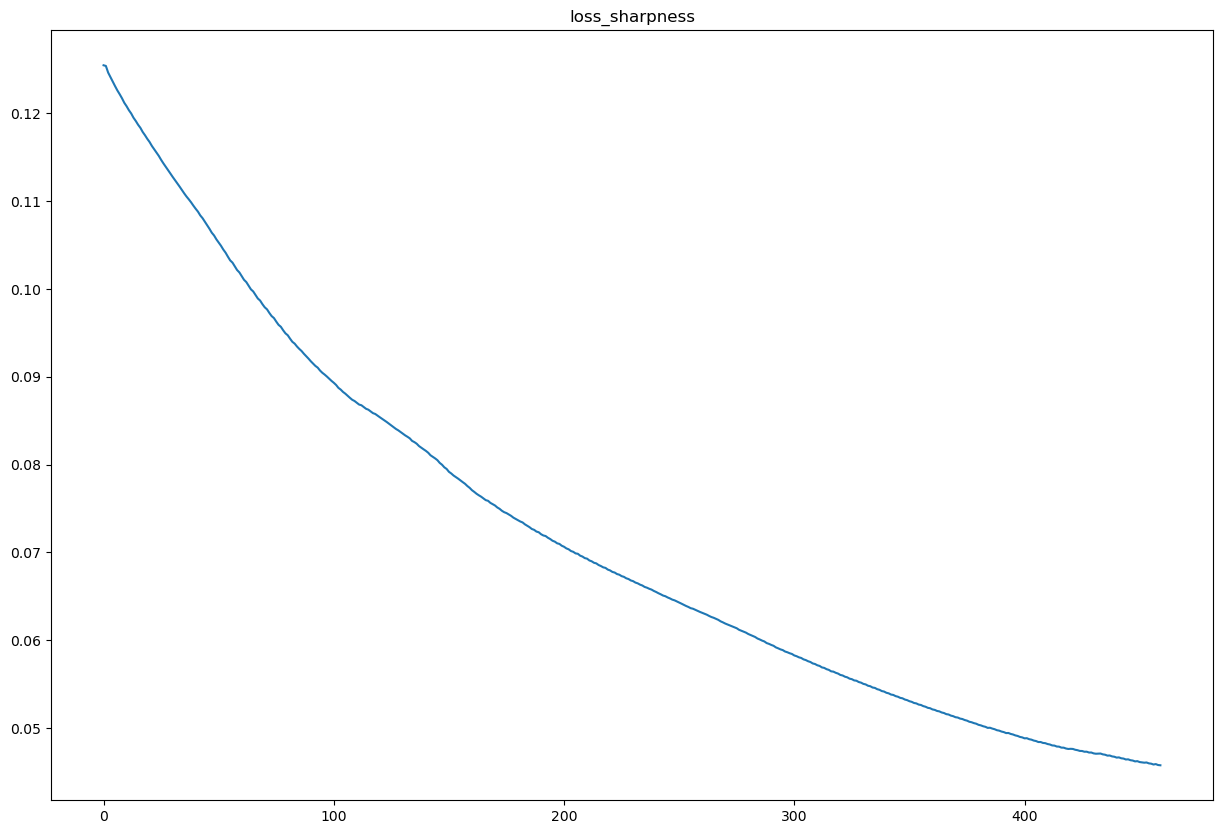

In [69]:
history, _ = process(model=model_greed, image=img, target_out=numpy.array(target_greed, numpy.float32), weight_class=0.1, weight_blur=0.9, err_method='abs')

### Plot history

pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()

(1, 2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


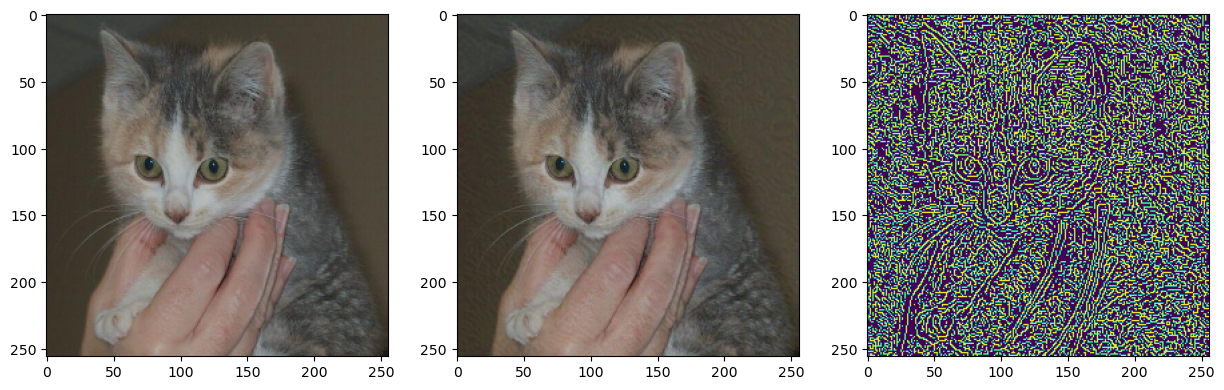

1/1 [==============================] - 0s 18ms/step
Predict for original image: [[9.9996614e-01 3.3805947e-05]]
1/1 [==============================] - 0s 15ms/step
Predict for ganged image:   [[1.6833343e-05 9.9998319e-01]]
1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predict for resized of changed image: [[8.7834058e-05 9.9991214e-01]]
3.725031316280365


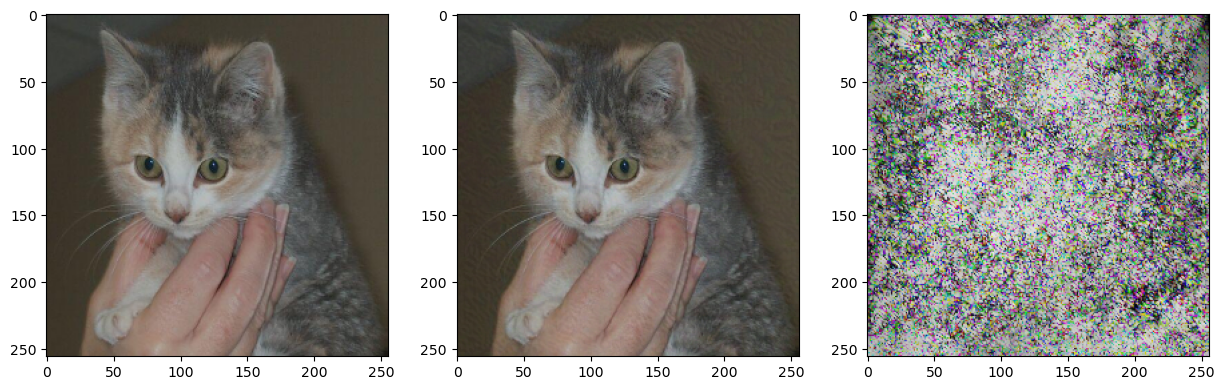

1/1 [==============================] - 0s 16ms/step
[[1.6833343e-05 9.9998319e-01]]
1/1 [==============================] - 0s 29ms/step
[[0.9880122  0.01198784]]
1/1 [==============================] - 0s 17ms/step
[[1.0000000e+00 7.0438216e-14]]


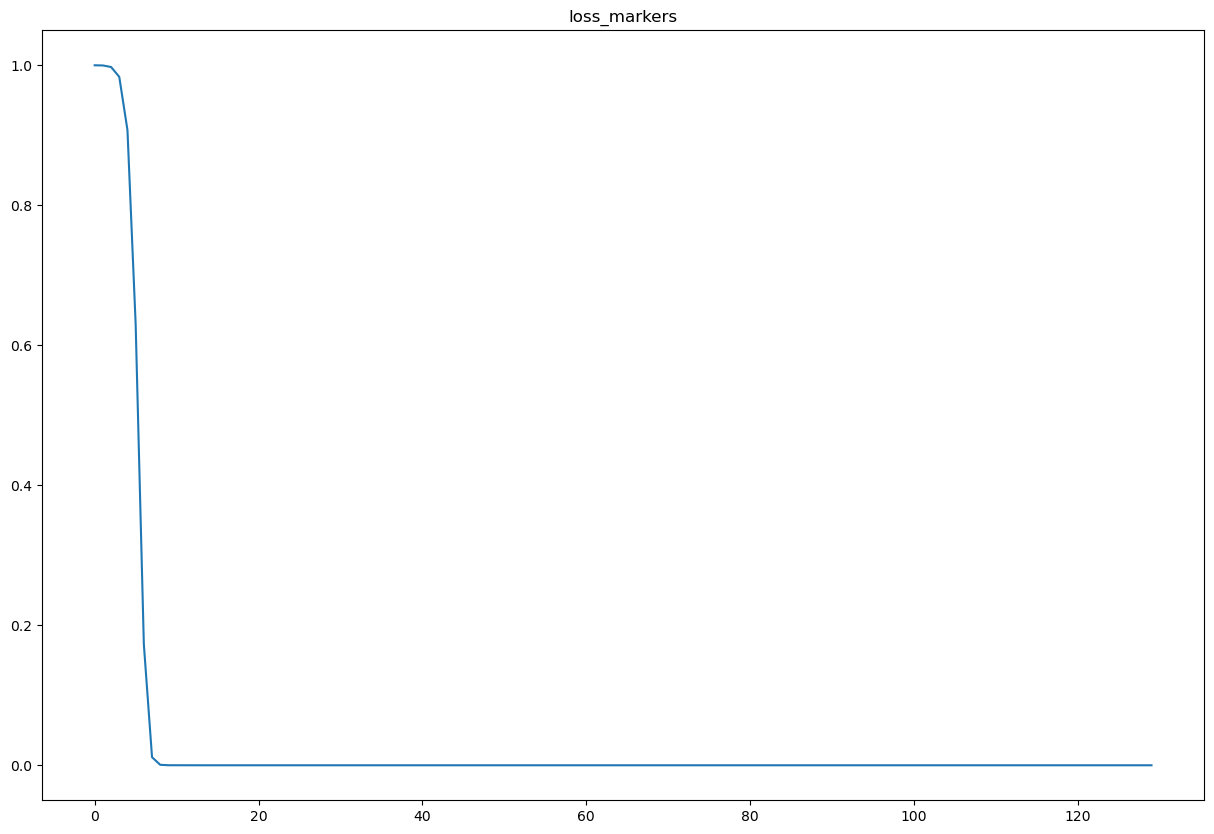

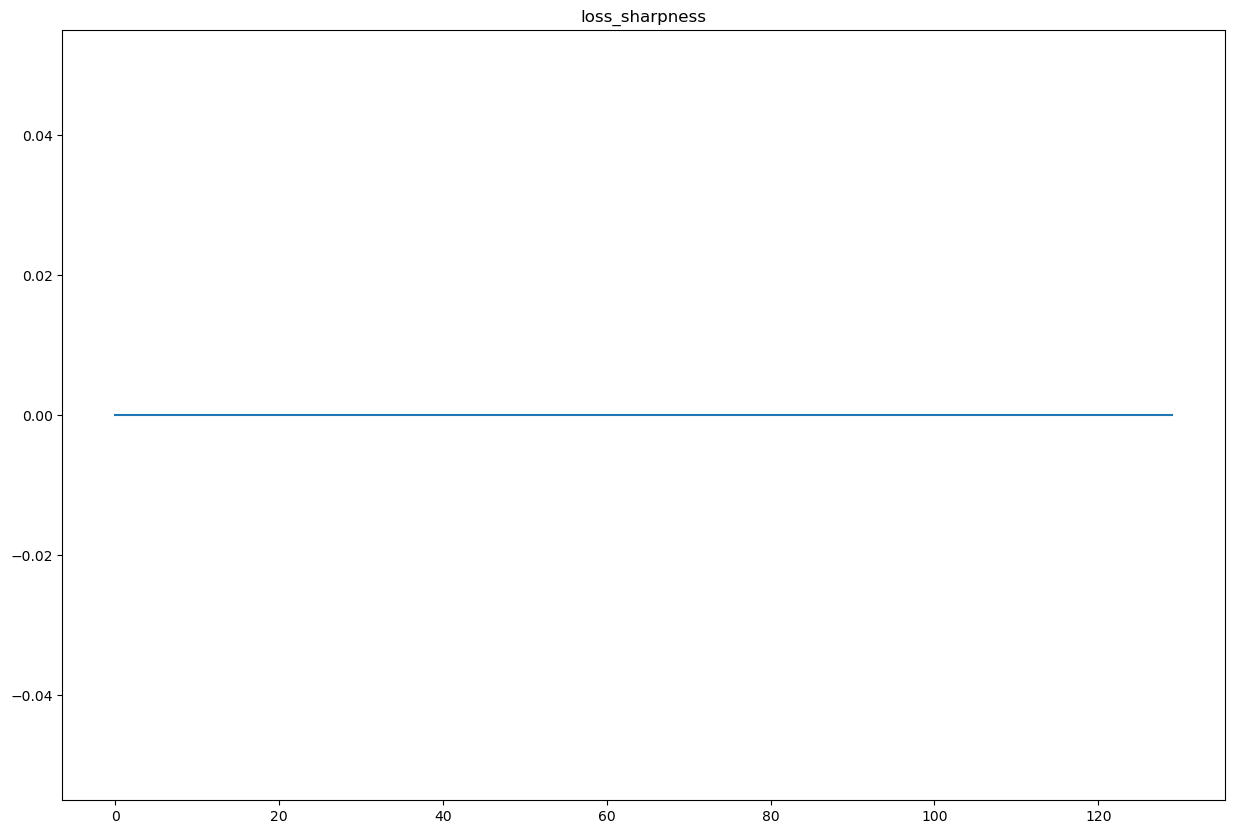

In [38]:
# Building "ideal" Cat ;-)

# ideal_cat_image = numpy.random.normal(0.5, 0.00001, (1, 256, 256, 3)).astype(numpy.float32)
ideal_cat_image = img.copy()
ideal_target    = numpy.array([[0.0, 1.0]], dtype=numpy.float32)

history, generated_image = process(model=model_greed, image=ideal_cat_image, target_out=ideal_target, weight_class=1.0, weight_blur=0.0, err_method='abs')

print(f'Predict for original image: {model_greed.predict(img)}')
print(f'Predict for ganged image:   {model_greed.predict(generated_image)}')
resized = cv2.resize(generated_image[0], (270, 270))[4:260, 4:260, :]
resized.shape = (1, 256, 256, 3)
# noised_img = generated_image + numpy.random.normal(0.0, 5.0/256, (1, 256, 256, 3))
print(f'Predict for resized of changed image: {model_greed.predict(noised_img)}')
diff = numpy.abs(img[0]-generated_image[0])
print(diff.max()*255)
diff = diff/diff.max()

pyplot.subplot(1, 3, 1)
pyplot.imshow(img[0])
pyplot.subplot(1, 3, 2)
pyplot.imshow(generated_image[0]) #, vmin=0.0, vmax=1.0)
pyplot.subplot(1, 3, 3)
pyplot.imshow(diff) #
pyplot.show()


print(model_greed.predict(generated_image))
print(model_mixer.predict(generated_image))
print(model_cnn.predict(generated_image))

pyplot.plot(history[:, 0])
pyplot.title('loss_markers')
pyplot.show()
pyplot.plot(history[:, 1])
pyplot.title('loss_sharpness')
pyplot.show()

(1, 8, 8, 2)


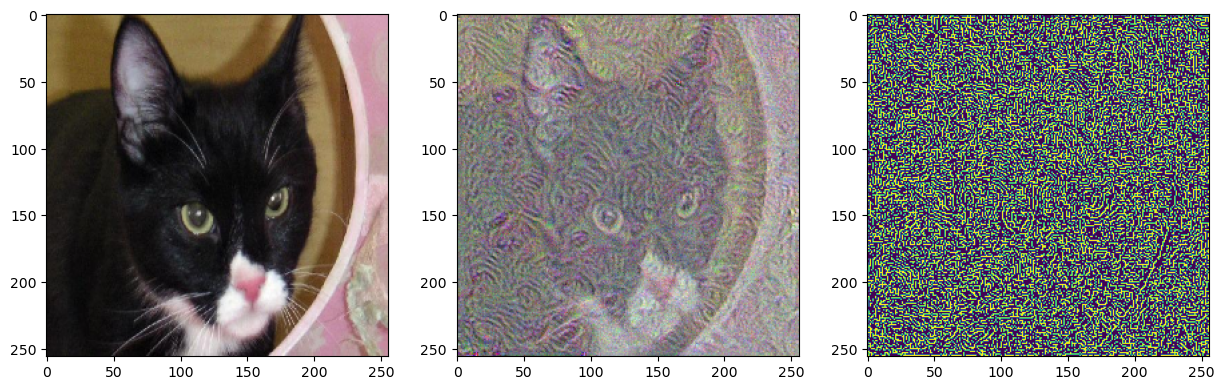

In [56]:
img = load_image('./data/PetImages/Cat/10001.jpg')

def process_greed_only(image, weight_class=5.0, weight_blur=1.0, err_method='abs'):
    history = list()
    model = tf.keras.Model(inputs=model_greed.input, outputs=model_greed.get_layer('concentrate_out_C').output)
    target = model(image).numpy()
    target[0, :, :, 0] = 100.0
    target[0, :, :, 1] = 0.0
    # t_max = numpy.max(target)
    # target[target<t_max] = 0.0
    print(target.shape)
    image_init = image.copy()

    video_writer = cv2.VideoWriter('transform.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, (256, 256))

    # High frequency filter
    def make_tf_filter_3x3(filter_3x3):
        filter_tf = numpy.zeros(shape=(3, 3, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_3x3
        filter_tf[:, :, 1, 1] = filter_3x3
        filter_tf[:, :, 2, 2] = filter_3x3
        return tf.constant(value=filter_tf, dtype=tf.float32)

    def make_tf_filter_5x5(filter_5x5):
        filter_tf = numpy.zeros(shape=(5, 5, 3, 3), dtype=numpy.float32)
        filter_tf[:, :, 0, 0] = filter_5x5
        filter_tf[:, :, 1, 1] = filter_5x5
        filter_tf[:, :, 2, 2] = filter_5x5
        return tf.constant(value=filter_tf, dtype=tf.float32)

    ## Filters 
    sobel_h = numpy.array([[0.2, 0.6, 0.2],[0.0, 0.0, 0.0],[-0.2,-0.6,-0.2]], dtype=numpy.float32)
    sobel_h = make_tf_filter_3x3(sobel_h)
    sobel_w = numpy.array([[0.2, 0.0,-0.2],[0.6, 0.0,-0.6],[ 0.2, 0.0,-0.2]], dtype=numpy.float32)
    sobel_w = make_tf_filter_3x3(sobel_w)

    # sobel_h = numpy.array([[0.1, 0.2, 0.4, 0.2, 0.1], [0.1, 0.1, 0.2, 0.1, 0.1], [0.0, 0.0, 0.0, 0.0, 0.0], [-0.1,-0.1,-0.2,-0.1,-0.1], [-0.1,-0.2,-0.4,-0.2,-0.1]], dtype=numpy.float32)
    # sobel_h = make_tf_filter_5x5(sobel_h)
    # sobel_w = numpy.array([[0.1, 0.1, 0.0,-0.1,-0.1], [0.2, 0.1, 0.0,-0.1,-0.2], [0.4, 0.2, 0.0,-0.2,-0.4], [ 0.2, 0.1, 0.0,-0.1,-0.2], [ 0.1, 0.1, 0. ,-0.1,-0.1]], dtype=numpy.float32)
    # sobel_w = make_tf_filter_5x5(sobel_w)

    s=1

    if err_method=='abs':
        err_type = tf.abs
    else:
        err_type = tf.square

    optimaser = tf.keras.optimizers.Adam(name='optimaser')# learning_rate=0.001, )

    image_init = tf.Variable(image_init, name='image_data')
    while True:
        for _ in range(10):
            with tf.GradientTape() as t:
                f = model(image_init)
                sh = tf.nn.conv2d(image_init, filters=sobel_h, strides=(1,1), padding='VALID')
                sw = tf.nn.conv2d(image_init, filters=sobel_w, strides=(1,1), padding='VALID')
                sh = err_type(sh)
                sw = err_type(sw)
                sh = tf.reduce_mean(sh)
                sw = tf.reduce_mean(sw)
                loss_markers = tf.reduce_mean(tf.square(target-f))*weight_class
                loss_sharpness = (sh+sw)*weight_blur
                loss = loss_markers + loss_sharpness #
            history.append( [loss_markers.numpy(), loss_sharpness.numpy()] )
            gradients = t.gradient(loss, image_init)
            # image_init.assign_sub(gradient*5.0)
            optimaser.apply_gradients(zip([gradients], [image_init]))
            image_init = tf.subtract(image_init, tf.reduce_min(image_init))
            image_init = image_init/tf.reduce_max(image_init)
            image_init = tf.Variable(image_init, name='image_data')
        if s<300:
            s=s+1
        else:
            break
        # class_of_init = model(image_init)
        # print(tf.reduce_max(gv).numpy())
        frame = (image_init.numpy()[0]*255).astype(dtype=numpy.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        class_weights = model_greed(image_init).numpy()[0]
        class_name = classes[numpy.argmax(class_weights)]
        cv2.putText(frame, f'{class_name}: {numpy.max(class_weights):.4f}', (20, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0))
        cv2.imshow('processing_image', frame)
        video_writer.write(frame)
        K = cv2.waitKey(1)
        if K==27:
            break
    video_writer.release()
    del video_writer
    # print(f.numpy())
    cv2.destroyAllWindows()

    pyplot.subplot(1, 3, 1)
    pyplot.imshow(image[0])
    pyplot.subplot(1, 3, 2)
    pyplot.imshow(image_init.numpy()[0]) #, vmin=0.0, vmax=1.0)
    pyplot.subplot(1, 3, 3)
    pyplot.imshow(cv2.Canny((image_init.numpy()[0, :, :, :]*255).astype(numpy.uint8), 10.0, 20.0)) #
    pyplot.show()
    return numpy.array(history), image_init.numpy()

history, _ = process_greed_only(img, weight_class=0.99, weight_blur=0.01, err_method='square')
